<p style="background-color:#16A085 ;color:black;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid #16A085 ;">Vegetable Classification</p>


<center><img src= "https://raw.githubusercontent.com/ashwinshetgaonkar/kaggle-kernel-images/main/vegetables.jpg" alt ="Road Accident" style='width:600px;'></center><br>

# <span style='font-weight:bold;color:#16A085'>Contents <hr></span>

[**1.Importing Libraries**](#import-lib)

[**2.Walk Through Directory**](#walk-through)

[**3.Visualizing the Training Data**](#viz-data)

[**4.Converting Data to ImageDatasets**](#conv-to-ds)

[**5.Defining Data Augmentation layer**](#data-aug)

[**6.model_0**](#m0)

 [**6.1. Building the model**](#m0-build)
 
 [**6.2. Compile the model**](#m0-compile)
 
 [**6.3.model Summary**](#m0-summary)
 
 [**6.4. Fit the model**](#m0-fit)
 
 [**6.5 model_0 result and learning curves**](#m0-result)


[**7.model_1**](#m1)

[**7.1.Load the Initial Weights of the model**](#m1-build)

[**7.2. Compile the model**](#m1-compile)

[**7.3. Fit the model**](#m1-fit)

[**7.4 model_1 result and learning curves**](#m1-result)

[**8.Visualizing and Analyzing the Predictions**](#analyse)

[**8.1.Confusion Matrix**](#cm)

[**8.2.Visualizing Wrong Predictions**](#preds)


# <span id='import-lib' style='font-weight:bold;color:#16A085'>1.Importing Libraries <hr></span>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from IPython.core.display import HTML,display

# <span id='walk-through' style='font-weight:bold;color:#16A085'>2.Walk Through Directory <hr></span>

In [2]:
def walk_through_dir(directory_name):
    
    '''
    Accepts the dirname as argument and prints the contents of each directory sequentially.
    It prints the sub-directories and number of images present in each.
    '''
    for dirpaths,dirnames,filenames in os.walk(directory_name):
        text=" <span style='color:green'><b>"+f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpaths}'"+"</b></span><hr>"
        display(HTML(text))




 <h3 ><b style='color:#16A085'>Note</b>:The output of the below cell is hidden ,you can expand the below cell to see it.</h3>


In [3]:
walk_through_dir('/kaggle/input')

# <span id='viz-data' style='font-weight:bold;color:#16A085'>3.Visualizing the Training Data <hr></span>

In [4]:
def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    display(HTML('<H2 style="color:#16A085"> <b>Data Visualization</b></H2><hr>'))
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),6)
    plt.figure(figsize=(20,5))
    for i in range(6):
        
        plt.subplot(1,6,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        img=tf.image.resize(img,(224,244))
        plt.imshow(img/255.0)
        plt.title(f'{target_class}\n{img.shape}')
        plt.xticks([]);
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    display(HTML('<hr>'))

In [5]:
train_dir='/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
val_dir='/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'
test_dir='/kaggle/input/vegetable-image-dataset/Vegetable Images/test'

2022-04-12 15:10:41.901916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 15:10:42.036395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 15:10:42.037190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 15:10:42.039427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

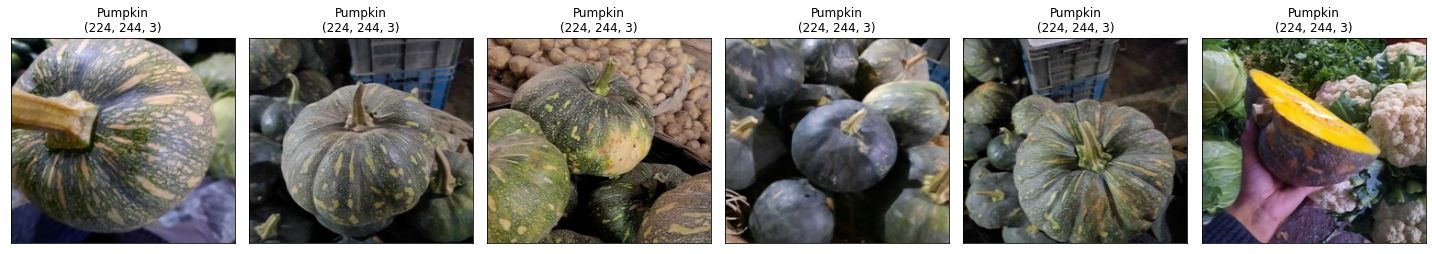

In [6]:
plot_random_image(train_dir)

# <span id='conv-to-ds' style='font-weight:bold;color:#16A085'>4.Converting Data to ImageDatasets <hr></span>

In [7]:
IMAGE_SIZE=(224,224)
EPOCHS=5

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

class_names=train_data.class_names

# prefetching the batches to improve training speed
train_data=train_data.prefetch(tf.data.AUTOTUNE)
val_data=val_data.prefetch(tf.data.AUTOTUNE)
test_data=test_data.prefetch(tf.data.AUTOTUNE)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


# <span id='data-aug' style='font-weight:bold;color:#16A085'>5.Defining Data Augmentation layer <hr></span>

In [8]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    layers.RandomZoom(0.2),
    # layers.Rescaling(scale=1.0/255)
],name='Data_Augmentation_Layer')
    

## <span id='m0' style='font-weight:bold;color:#16A085'>6.model_0 </span>
<h3>- Using efficientnetB0 as the feature extraction layer and training the model with 20% of training batches.<hr></h3>

## <span id='m0-build' style='font-weight:bold;color:#16A085'>6.1. Building the model</span>
<h3> Using efficientnetB0 as the feature extraction layer.<hr></h3>

In [9]:
mixed_precision.set_global_policy('mixed_float16')

inputs=layers.Input(shape=(224,224,3),name='input_layer')

base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

x=data_augmentation(inputs)

x=base_model(x,training=False)

x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
num_classes=len(class_names)
outputs=layers.Dense(num_classes,activation='softmax',dtype=tf.float32,name="Output_layer")(x)

model=keras.Model(inputs,outputs,name="model")

2022-04-12 15:10:45.972518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


16719872/16705208 [==============================] - 0s 0us/step


In [10]:
# save the initial weights of the model
model.save_weights('initial_weights.ckpt')

## <span id='m0-compile' style='font-weight:bold;color:#16A085'>6.2. Compile the model<hr></span>

In [11]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

## <span id='m0-summary' style='font-weight:bold;color:#16A085'>6.3.model Summary<hr></span>

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Data_Augmentation_Layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_Average_Pool_2D (Glob (None, 1280)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 15)                19215     
Total params: 4,068,786
Trainable params: 19,215
Non-trainable params: 4,049,571
_________________________________________________________________


## <span id='m0-fit' style='font-weight:bold;color:#16A085'>6.4. Fit the model<hr></span>

## <span  style='font-weight:bold;color:#16A085'>6.4.1. Defining the callback function<hr></span>

In [13]:
def create_model_check_point_callback(checkpoint_path,monitor='val_loss'):
    """
    Takes the path where to save the best model weights obtained during training.
    """
    model_checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(
        
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb


In [14]:
ModelCheckPoint_model_cb=create_model_check_point_callback('ModelCheckPoints/model.ckpt')

history_of_model=model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=int (0.2*len(train_data)),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[ModelCheckPoint_model_cb]
)

Epoch 1/5


2022-04-12 15:10:54.411583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 15:10:56.971346: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 88s 809ms/step - loss: 0.9126 - accuracy: 0.8212 - val_loss: 0.2569 - val_accuracy: 0.9670

Epoch 00001: val_loss improved from inf to 0.25692, saving model to ModelCheckPoints/model.ckpt
Epoch 2/5
93/93 [==============================] - 43s 464ms/step - loss: 0.2312 - accuracy: 0.9630 - val_loss: 0.1297 - val_accuracy: 0.9833

Epoch 00002: val_loss improved from 0.25692 to 0.12973, saving model to ModelCheckPoints/model.ckpt
Epoch 3/5
93/93 [==============================] - 34s 369ms/step - loss: 0.1432 - accuracy: 0.9765 - val_loss: 0.0863 - val_accuracy: 0.9890

Epoch 00003: val_loss improved from 0.12973 to 0.08629, saving model to ModelCheckPoints/model.ckpt
Epoch 4/5
93/93 [==============================] - 33s 356ms/step - loss: 0.1038 - accuracy: 0.9832 - val_loss: 0.0664 - val_accuracy: 0.9900

Epoch 00004: val_loss improved from 0.08629 to 0.06643, saving model to ModelCheckPoints/model.ckpt
Epoch 5/5
93/93 [=========================

## <span id='m0-result' style='font-weight:bold;color:#16A085'>6.5. model_0 result and learning curves<hr></span>

In [15]:
# load the best weights
model.load_weights('ModelCheckPoints/model.ckpt')

In [16]:
val_loss,val_acc=model.evaluate(val_data)

94/94 [==============================] - 4s 38ms/step - loss: 0.0531 - accuracy: 0.9920


In [17]:
text="<hr><span style='font-weight:bold; color:black'>"+f"Loss on Val Dataset: <b style='font-weight:bold; color:#16A085'>{val_loss:.4f}</b>"+f"<br><br> Accuracy on Val Dataset: <b style='font-weight:bold; color:#16A085'>{val_acc*100:.2f}%</b>"+"</span><hr>"
display(HTML(text))

In [18]:
test_loss,test_acc=model.evaluate(test_data)

94/94 [==============================] - 11s 116ms/step - loss: 0.0582 - accuracy: 0.9910


In [19]:
text="<hr><span style='font-weight:bold; color:black'>"+f"Loss on Test Dataset: <b style='font-weight:bold; color:#16A085'>{test_loss:.4f}</b>"+f"<br><br> Accuracy on Test Dataset: <b style='font-weight:bold; color:#16A085'>{test_acc*100:.2f}%</b>"+"</span><hr>"
display(HTML(text))

In [20]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    display(HTML("<h3 style='text-align:center; font-weight:bold; color:#16A085'> Model Performance Curves</h3><hr>"))
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);


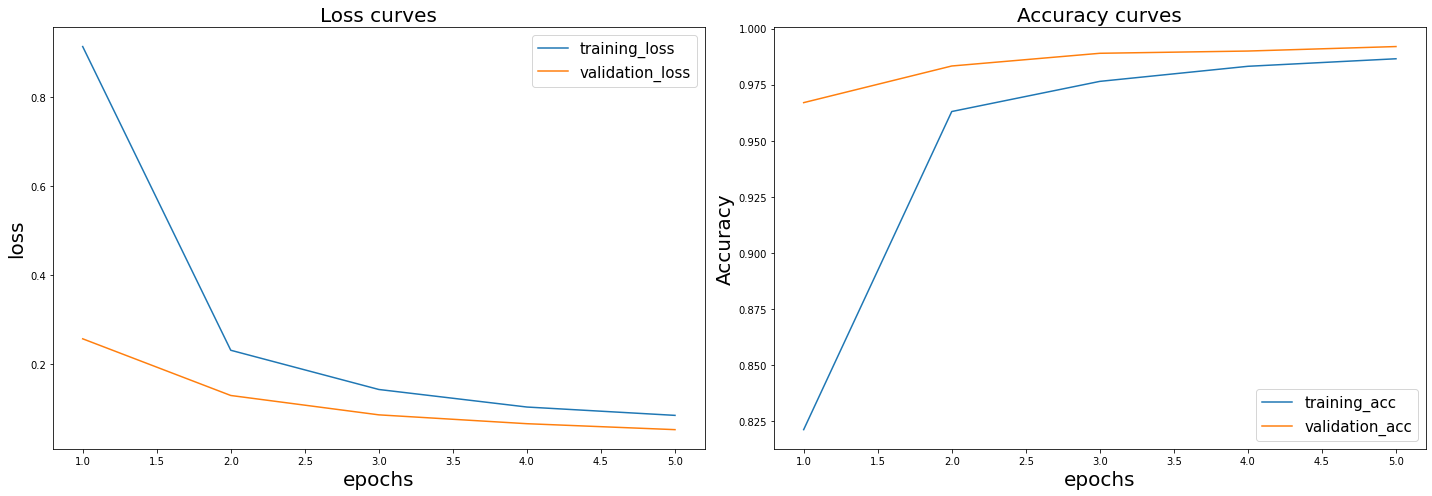

In [21]:
plot_loss_curves(history_of_model)

<h3 ><b style=' color:#16A085'>Inference:</b>The model performed exceeding well on training with 20% of the batches of the train data,
now training for 100% train data.</h3>


 ## <span id='m1' style='font-weight:bold;color:#16A085'>7.model_1</span>
<h3>- Using efficientnetB0 as the feature extraction layer and training the model with 100% of training batches.<hr></h3>
 


## <span id='m1-build' style='font-weight:bold;color:#16A085'>7.1.Load the Initial Weights of the model</span>
<h3>- Using efficientnetB0 as the feature extraction layer and training the model with 100% of training batches.<hr></h3>

In [22]:
model.load_weights('initial_weights.ckpt')

## <span id='m1-compile' style='font-weight:bold;color:#16A085'>7.2.Compile the model<hr></span>


In [23]:

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

## <span id='m1-fit' style='font-weight:bold;color:#16A085'>7.3.Fit the model<hr></span>

In [24]:
ModelCheckPoint_model_cb=create_model_check_point_callback('ModelCheckPoints/model_1.ckpt')

history_of_model_1=model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[ModelCheckPoint_model_cb]
)

Epoch 1/5
469/469 [==============================] - 33s 59ms/step - loss: 0.2953 - accuracy: 0.9468 - val_loss: 0.0532 - val_accuracy: 0.9927

Epoch 00001: val_loss improved from inf to 0.05323, saving model to ModelCheckPoints/model_1.ckpt
Epoch 2/5
469/469 [==============================] - 117s 250ms/step - loss: 0.0528 - accuracy: 0.9903 - val_loss: 0.0274 - val_accuracy: 0.9950

Epoch 00002: val_loss improved from 0.05323 to 0.02742, saving model to ModelCheckPoints/model_1.ckpt
Epoch 3/5
469/469 [==============================] - 88s 188ms/step - loss: 0.0308 - accuracy: 0.9950 - val_loss: 0.0199 - val_accuracy: 0.9960

Epoch 00003: val_loss improved from 0.02742 to 0.01986, saving model to ModelCheckPoints/model_1.ckpt
Epoch 4/5
469/469 [==============================] - 73s 156ms/step - loss: 0.0236 - accuracy: 0.9952 - val_loss: 0.0139 - val_accuracy: 0.9970

Epoch 00004: val_loss improved from 0.01986 to 0.01389, saving model to ModelCheckPoints/model_1.ckpt
Epoch 5/5
469/46

## <span id='m1-result' style='font-weight:bold;color:#16A085'>7.4.model_1_result and learning curves<hr></span>

In [25]:
# load the best performing model
model.load_weights('ModelCheckPoints/model_1.ckpt')

In [26]:
val_loss,val_acc=model.evaluate(val_data)

94/94 [==============================] - 4s 37ms/step - loss: 0.0111 - accuracy: 0.9977


In [27]:
text="<hr><span style='font-weight:bold; color:black'>"+f"Loss on Val Dataset: <b style='font-weight:bold; color:#16A085'>{val_loss:.4f}</b>"+f"<br><br> Accuracy on Val Dataset: <b style='font-weight:bold; color:#16A085'>{val_acc*100:.2f}%</b>"+"</span><hr>"
display(HTML(text))

In [28]:
test_loss,test_acc=model.evaluate(test_data)

94/94 [==============================] - 4s 40ms/step - loss: 0.0110 - accuracy: 0.9983


In [29]:
text="<hr><span style='font-weight:bold; color:black'>"+f"Loss on Test Dataset: <b style='font-weight:bold; color:#16A085'>{test_loss:.4f}</b>"+f"<br><br> Accuracy on Test Dataset: <b style='font-weight:bold; color:#16A085'>{test_acc*100:.2f}%</b>"+"</span><hr>"
display(HTML(text))

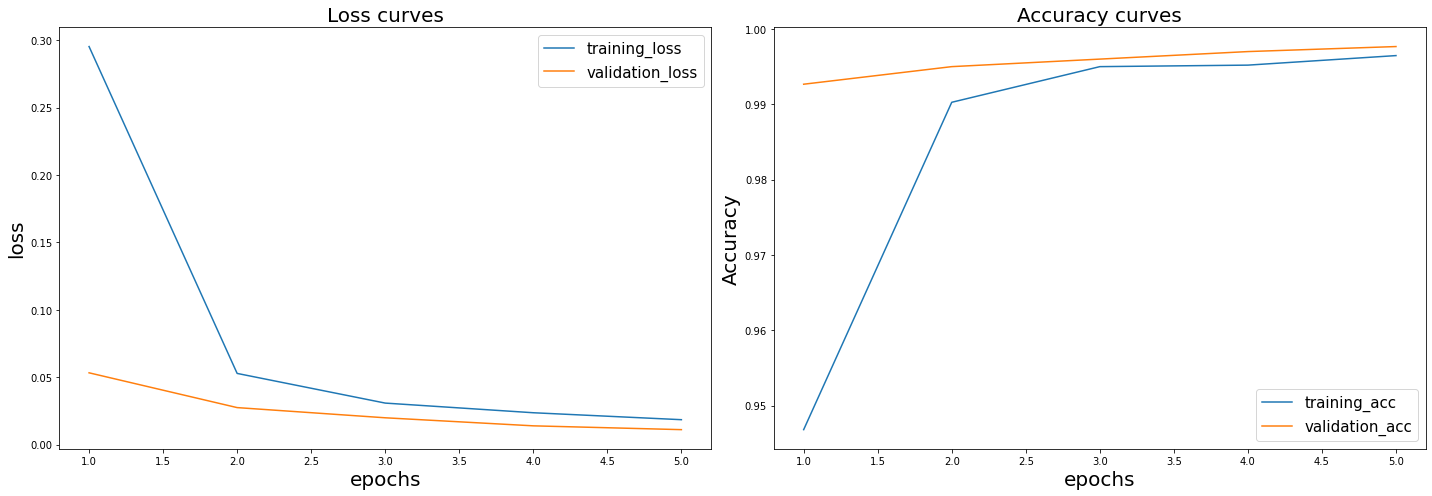

In [30]:
plot_loss_curves(history_of_model_1)

<h3 ><b style=' color:#16A085'>Inference:</b> The model performed even better on training with 100% of the batches of the train data,
now lets visualize and analyse the predictions made by the model.</h3>

# <span id='analyse' style='font-weight:bold;color:#16A085'>8.Visualizing and Analyzing the Predictions <hr></span>

In [31]:
# make predictions on the test data
pred_proba=model.predict(test_data)
pred_proba[:2]

array([[9.9942207e-01, 9.0616572e-07, 9.3745048e-06, 1.4466697e-06,
        4.2456435e-05, 2.7493735e-08, 1.5725991e-08, 1.3691616e-05,
        2.3039814e-07, 5.0720817e-04, 2.1401293e-07, 7.0753930e-11,
        3.7606245e-07, 4.3777166e-07, 1.4146126e-06],
       [9.9999559e-01, 4.8220672e-09, 7.6561824e-09, 1.2899395e-09,
        1.1655874e-06, 5.3929656e-09, 5.7001116e-11, 2.4942730e-07,
        1.4546896e-09, 2.5775826e-06, 3.1169772e-10, 1.7787341e-12,
        3.4838585e-10, 4.4815675e-07, 9.6544639e-09]], dtype=float32)

In [32]:
pred_class_number=tf.argmax(pred_proba,axis=1).numpy()
pred_class_number[:5]

array([0, 0, 0, 0, 0])

In [33]:
# true labels
y_labels=[]
for _,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())

y_labels[:5]

[0, 0, 0, 0, 0]

In [34]:
class_names[:5]

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli']

## <span id='cm' style='font-weight:bold;color:#16A085'>8.1.Confusion Matrix <hr></span>

In [35]:
def make_confusion_matrix(y_true,y_preds,class_names):
    cm=confusion_matrix(y_true,y_preds)
    plt.figure(figsize=(24,20))
    sns.heatmap(cm,annot=True,cmap='summer',fmt='.0f')
    display(HTML("<h2 style='font-weight:bold; color:#16A085; text-align:center;'>Confusion Matrix</h2><hr>"))
    plt.ylabel("True values",size=20)
    plt.xlabel('Predicted values',size=20)
    plt.xticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=60)
    plt.yticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=0)

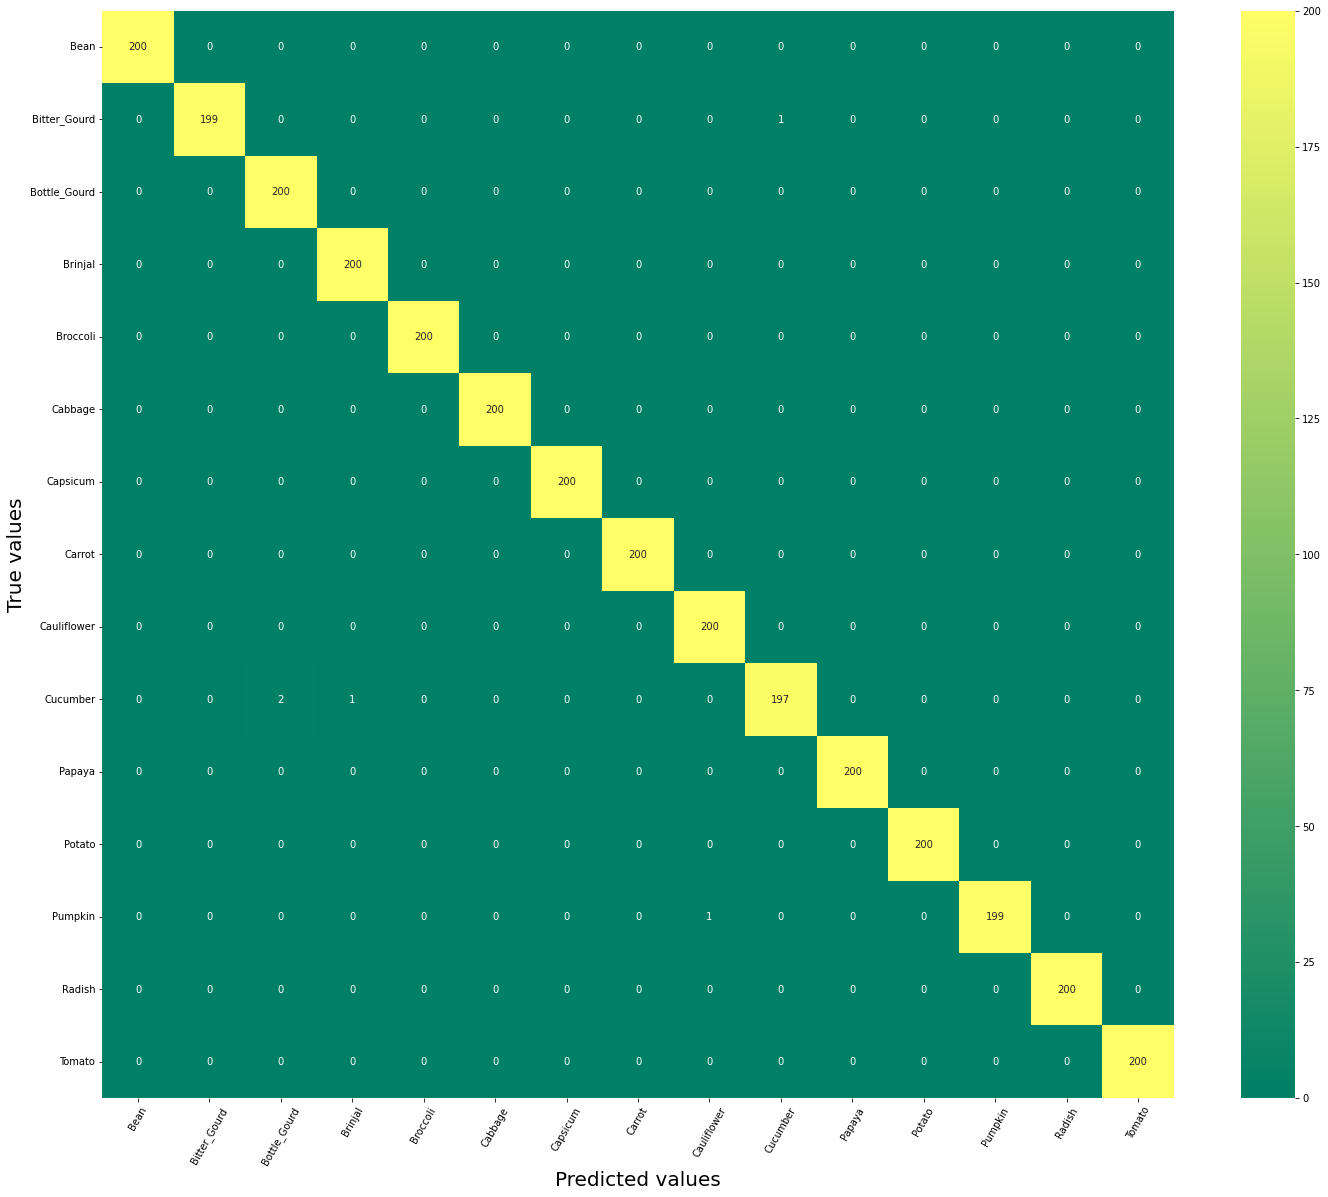

In [36]:
make_confusion_matrix(y_labels,pred_class_number,class_names)

<h3 ><b style=' color:#16A085'>Inference:</b> There are only a handfull of instances that the model failed to classify properly,lets visualize these for better understanding the performance of the model.</h3>

In [37]:
# filepaths of the test data images
filepaths=[]
for filepath in test_data.list_files(test_dir+'/*/*.jpg',shuffle=False):
    filepaths.append(filepath.numpy())

filepaths[:2]

[b'/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Bean/0001.jpg',
 b'/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Bean/0002.jpg']

In [38]:
# compiling all the data into a Dataframe for ease of working
pred_df=pd.DataFrame({
    'filepaths':filepaths,
    'y_true':y_labels,
    'y_pred':pred_class_number,
    'pred_conf':pred_proba.max(axis=1),
    'actual_class_name':[class_names[i] for i in y_labels],
    'pred_class_name':[class_names[i] for i in pred_class_number]
     })
pred_df.head()

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'/kaggle/input/vegetable-image-dataset/Vegeta...,0,0,0.999422,Bean,Bean
1,b'/kaggle/input/vegetable-image-dataset/Vegeta...,0,0,0.999996,Bean,Bean
2,b'/kaggle/input/vegetable-image-dataset/Vegeta...,0,0,0.999785,Bean,Bean
3,b'/kaggle/input/vegetable-image-dataset/Vegeta...,0,0,0.999282,Bean,Bean
4,b'/kaggle/input/vegetable-image-dataset/Vegeta...,0,0,0.999773,Bean,Bean


In [39]:
# storing the wrong predictions made by the model in a seperate df
pred_wrong_df=pred_df[pred_df['y_true']!=pred_df['y_pred']].reset_index(drop=True)
pred_wrong_df

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'/kaggle/input/vegetable-image-dataset/Vegeta...,1,9,0.574263,Bitter_Gourd,Cucumber
1,b'/kaggle/input/vegetable-image-dataset/Vegeta...,9,2,0.519368,Cucumber,Bottle_Gourd
2,b'/kaggle/input/vegetable-image-dataset/Vegeta...,9,3,0.500833,Cucumber,Brinjal
3,b'/kaggle/input/vegetable-image-dataset/Vegeta...,9,2,0.787305,Cucumber,Bottle_Gourd
4,b'/kaggle/input/vegetable-image-dataset/Vegeta...,12,8,0.869871,Pumpkin,Cauliflower


In [40]:
def load_and_prep_image(filename,img_shape=224,scale=True):
    
    '''
    reads an image from the filename and turns it into a tensor,
    and reshapes it to the specified size.
    
    args:
    filename(str):path to the target image.
    img_shahape(a,b,c)=target shape.
    scale(boolean): specifies wheather scaling is required to be done or not.
    
    returns:
    image tensor with the target shape.
    '''
    
    img=tf.io.read_file(filename)
    img=tf.io.decode_image(img,channels=3)
    img=tf.image.resize(img,size=[img_shape,img_shape])
    
    if scale:
        img=img/255.0
    return img

## <span id='preds' style='font-weight:bold;color:#16A085'>8.2.Visualizing Wrong Predictions <hr></span>

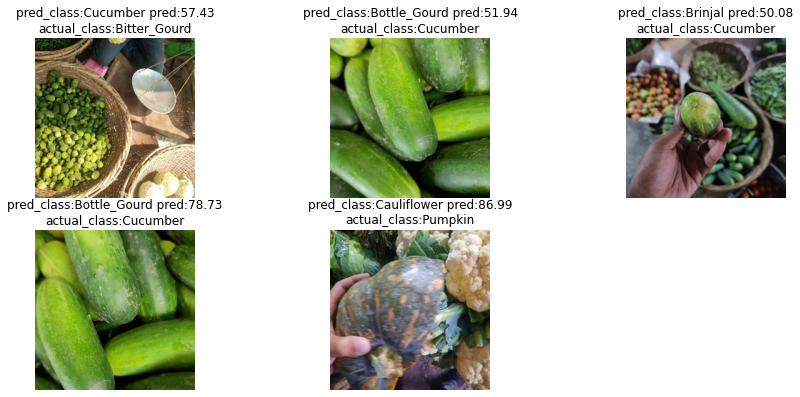

In [41]:
images_to_view=8
start_index=0
plt.figure(figsize=(15,10))
for i,row in enumerate(pred_wrong_df[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img=load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_p,act_cls,prd_cls=row
    plt.imshow(img/255.0)
    plt.title(f"pred_class:{prd_cls} pred:{pred_p*100:.2f}\nactual_class:{act_cls}")
    plt.axis(False)

<h3 ><b style=' color:#16A085'>Inference:</b><br><br>1. There are cases wherein the images contain more than one classes so this error can be rectified by properly cleaning the dataset such that each image should contain only one type of vegetable.<br><br>
2.In some cases the model fails to correctly classify the vegetable when the test image has the vegetable at an akward angle,this can be rectified by including such images in the training dataset<br><br>3.In some cases the model gets confused between Cucumber/Bottle Gourd/Papaya because of their similar shapes and sizes,this can be rectified by including more training images of these classes taken from different angles.</h3>




<h2 style='text-align:center;color:#16A085;font-weight:bold'> Do share your feedback in the comments section,I hope you found it to be helpful.🙌</h2>


<p style="background-color:#16A085;color:black;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid #16A085;">Thank You !!!😄<hr></p>